In [1]:
print("Hello, customer!")

Hello, customer!


In [2]:
from typing_extensions import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages

In [3]:
class state(TypedDict):
    messages: Annotated[list, add_messages]
    user_msg: str

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate  

c:\Users\hp\anaconda3\envs\pizzaapi\lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [6]:
from langchain_groq import ChatGroq

In [7]:
llm = ChatGroq(model="openai/gpt-oss-20b", api_key=os.getenv("GROQ_API_KEY"))

In [8]:
llm.invoke("Hello, customer!").content

'Hello! How can I assist you today?'

In [9]:
prompt = ChatPromptTemplate.from_messages(
    [("system", "You are a customer care bot, tell me whether the given problem is based on Billing issue, Technical issue or Feedback"),
     ("user", "issue:{issue}")
     
     ]
)

chain = prompt | llm

In [10]:
chain.invoke({"issue": "My internet is not working properly."})

AIMessage(content='The issue is a **Technical issue**.', additional_kwargs={'reasoning_content': 'We have a conversation: user says "issue:My internet is not working properly." The task: "You are a customer care bot, tell me whether the given problem is based on Billing issue, Technical issue or Feedback". So we need to classify the issue into one of three categories: Billing issue, Technical issue, Feedback.\n\nThe user\'s issue: "My internet is not working properly." This is a technical issue. So we respond accordingly. The answer should be something like "This appears to be a Technical issue." Probably just that.'}, response_metadata={'token_usage': {'completion_tokens': 127, 'prompt_tokens': 106, 'total_tokens': 233, 'completion_time': 0.129190481, 'completion_tokens_details': {'reasoning_tokens': 109}, 'prompt_time': 0.007161652, 'prompt_tokens_details': None, 'queue_time': 0.045049978, 'total_time': 0.136352133}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e1896

In [11]:
chain.invoke({"issue": "I was charged twice for my subscription."}).content

'**Billing issue**'

In [12]:
from langgraph.graph import StateGraph, START, END
graph_builder = StateGraph(state)

def interface_llm(state: state):
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are a customer care bot, tell me whether the given problem is based on Billing issue, Technical issue or Feedback"),
         ("user", "issue:{issue}")
         
         ]
    )
    chain = prompt | llm
    user_msg = state["messages"][-1].content
    response = chain.invoke({"issue": user_msg})
    return {"messages": state["messages"] + [response]}



def billing_llm(state: state):
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are a billing support bot, help the user with their billing issue."),
         ("user", "issue:{issue}")
         
         ]
    )
    chain = prompt | llm
    user_msg = state["messages"][-2].content
    response = chain.invoke({"issue": user_msg})
    return {"messages": state["messages"] + [response]}


def technical_llm(state: state):
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are a technical support bot, help the user with their technical issue."),
         ("user", "issue:{issue}")
         
         ]
    )
    chain = prompt | llm
    user_msg = state["messages"][-2].content
    response = chain.invoke({"issue": user_msg})
    return {"messages": state["messages"] + [response]}


def feedback_llm(state: state):
    prompt = ChatPromptTemplate.from_messages(
        [("system", "You are a feedback support bot, help the user with their feedback."),
         ("user", "issue:{issue}")
         
         ]
    )
    chain = prompt | llm
    user_msg = state["messages"][-2].content
    response = chain.invoke({"issue": user_msg})
    return {"messages": state["messages"] + [response]}


def router_decision(state: state):
    classification = state["messages"][-1].content.lower().strip()

    if "billing" in classification:
        return "billing_node"
    elif "technical" in classification:
        return "technical_node"
    else:
        return "feedback_node"  

# add nodes
graph_builder.add_node("interface_node", interface_llm)
graph_builder.add_node("billing_node", billing_llm)
graph_builder.add_node("technical_node", technical_llm)
graph_builder.add_node("feedback_node", feedback_llm)



# add edges
graph_builder.add_edge(START, "interface_node")
graph_builder.add_conditional_edges(
    "interface_node",
    router_decision,
    {
        "billing_node": "billing_node",
        "technical_node": "technical_node",
        "feedback_node": "feedback_node"
    }
)

graph_builder.add_edge("billing_node", END)
graph_builder.add_edge("technical_node", END)
graph_builder.add_edge("feedback_node", END)

graph = graph_builder.compile()

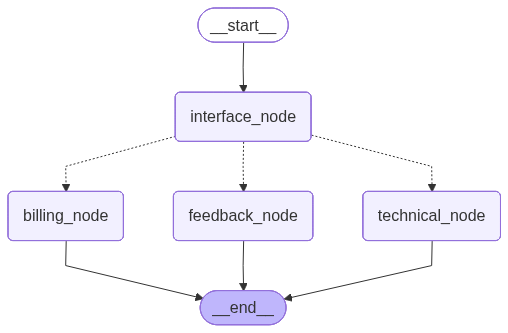

In [13]:
graph

In [26]:
response = graph.invoke({'messages': 'I was charged twice for the item i bought.'})['messages'][-1].content

In [27]:
print(response)

I’m sorry to hear that you’ve been double‑charged. Let’s get this sorted out quickly.

**To help me investigate, could you please provide:**

1. **Order number / transaction ID** (if you have it handy).  
2. **Date and time** of the purchase.  
3. **Payment method** used (e.g., credit card, PayPal, etc.).  
4. **Any screenshots** of the charge(s) if you have them.

Once I have that information, I’ll check our records and arrange a refund for the duplicate charge. If you prefer, you can also reach out to our billing support line at **1‑800‑555‑BILL** (1‑800‑555‑2529) or email **billing@ourcompany.com**.  

Thank you for your patience, and I’ll do my best to resolve this as quickly as possible.
